In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("/content/drive/MyDrive/My_Data/Sale_price_prediction/dataset/TRAIN.csv")
test = pd.read_csv("/content/drive/MyDrive/My_Data/Sale_price_prediction/dataset/TEST.csv")

train.StateHoliday = np.where(train.StateHoliday==0,"0",train.StateHoliday.astype(str))
test.StateHoliday = np.where(test.StateHoliday==0,"0",test.StateHoliday.astype(str))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [ ]:
test.head(3)

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,767,1,2013-04-01,0,0,b,1
1,1111,6,2013-03-16,1,0,0,0
2,45,4,2013-08-01,1,1,0,1


# One Hot Encoding

In [ ]:
holidays1=train['StateHoliday']
holidays2=test['StateHoliday']

train['StateHoliday_a']=(holidays1=='a')*1.0
train['StateHoliday_b']=(holidays1=='b')*1.0
train['StateHoliday_c']=(holidays1=='c')*1.0

test['StateHoliday_a']=(holidays2=='a')*1.0
test['StateHoliday_b']=(holidays2=='b')*1.0
test['StateHoliday_c']=(holidays2=='c')*1.0

In [ ]:
train.drop("Customers",axis=1,inplace=True)

In [ ]:
## We are dropping StateHoliday=='c' as the testdataset doesn't have this parameter
train.drop(index = train[train["StateHoliday"]=='c'].index,inplace=True)

In [ ]:
train = pd.get_dummies(train,columns=["StateHoliday"],drop_first=False)
test = pd.get_dummies(test,columns=["StateHoliday"],drop_first=False)

# Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def label_encoding(data):
  data[["StateHoliday"]] = data[["StateHoliday"]].apply(le.fit_transform)

label_encoding(train)
label_encoding(test)

In [ ]:
## Handling Date-time feature

def date_time(data):
  
  data["Date"] = pd.to_datetime(data['Date'], errors='coerce')
  data["Year"] = data.Date.dt.year
  data["Month"] = data.Date.dt.month
  data["Day"] = data.Date.dt.day

date_time(train)
date_time(test)

In [ ]:
train.drop("Date",axis=1,inplace=True)
test.drop("Date",axis=1,inplace=True)
#train.drop("StateHoliday",axis=1,inplace=True)
#test.drop("StateHoliday",axis=1,inplace=True)


In [ ]:
display(train.head(),test.head())

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,Year,Month,Day
0,1,5,5263,1,1,1,1,0,0,2015,7,31
1,2,5,6064,1,1,1,1,0,0,2015,7,31
2,3,5,8314,1,1,1,1,0,0,2015,7,31
3,4,5,13995,1,1,1,1,0,0,2015,7,31
4,5,5,4822,1,1,1,1,0,0,2015,7,31


,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,Year,Month,Day
0,767,1,0,0,1,0,0,1,2013,4,1
1,1111,6,1,0,0,1,0,0,2013,3,16
2,45,4,1,1,1,1,0,0,2013,8,1
3,500,4,1,0,1,1,0,0,2013,5,23
4,82,2,1,0,1,1,0,0,2013,8,6


In [ ]:
X = train.drop("Sales",axis=1)
y = train.Sales

In [ ]:
## We try to scale the data as there are diiferent range of values
def Standard_Scaling(data):
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  feature_scale = [feature for feature in data.columns]
  data = pd.DataFrame(scaler.fit_transform(data[feature_scale]),columns = feature_scale)
  return data


X = Standard_Scaling(X)
test = Standard_Scaling(test)
display(X.head(3),test.head(3))

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,Year,Month,Day
0,-1.731317,0.49965,0.447311,1.269763,2.230399,0.166094,-0.144837,-0.079623,1.220109,0.237704,1.746351
1,-1.728211,0.49965,0.447311,1.269763,2.230399,0.166094,-0.144837,-0.079623,1.220109,0.237704,1.746351
2,-1.725105,0.49965,0.447311,1.269763,2.230399,0.166094,-0.144837,-0.079623,1.220109,0.237704,1.746351


,Store,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,Year,Month,Day
0,0.648169,-1.497488,-2.238881,-0.788954,2.039824,-6.116721,-0.138137,11.655230,0.0,-0.398454,-1.664883
1,1.717234,1.002520,0.446652,-0.788954,-0.490238,0.163486,-0.138137,-0.085798,0.0,-0.784972,0.040431
2,-1.595625,0.002517,0.446652,1.267501,2.039824,0.163486,-0.138137,-0.085798,0.0,1.147618,-1.664883


# Model Building

In [ ]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=21,test_size=0.2)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape=[X_train.shape[1]]
no_target_columns = 1
model=keras.Sequential([
   layers.Dense(150,activation='relu',input_shape=input_shape,kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(150,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(150,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(150,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),

   layers.Dense(50,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.2),
   layers.Dense(50,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.2),
   layers.Dense(50,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.2),
   layers.Dense(36,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.3),

   layers.Dense(1,activation = 'linear')
])

In [ ]:
# Initializing the Optimizer values
optimizer=keras.optimizers.RMSprop(0.01)
metric1=keras.metrics.RootMeanSquaredError()
metric2=keras.metrics.MeanAbsoluteError()
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[metric1])

In [ ]:
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

history=model.fit(
    X_train,y_train,
    validation_split=0.7,
    epochs=100,
    batch_size=512,
    callbacks = [early_stopping],
    #validation_data=(X_test,y_test)
)

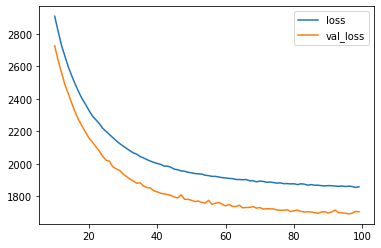

In [ ]:
# Plotting the DataFrame
history_df=pd.DataFrame(history.history)
history_df.loc[10:,['loss','val_loss']].plot()

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_predictions = pd.DataFrame({'Predicted Price': test_predictions,'Actual Price':y_test.values.flatten()})
test_predictions.head(20)

In [ ]:
prediction = model.predict(test)
prediction = pd.DataFrame(prediction,columns=["Sales"])

In [ ]:
prediction.index.names=["Index"]
prediction.head()

,Sales
Index,
0,0.672516
1,5298.159668
2,6989.857422
3,5362.865723
4,5811.851562


In [ ]:
prediction.to_csv("pred_file.csv")

# Hyperparameter Tuning

In [ ]:
pip install keras-tuner

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=4,
    executions_per_trial=2,
    directory='project',
    project_name='Sales_price_prediction')

In [ ]:
tuner.search_space_summary()


Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test),callbacks=[stop_early])

Trial 4 Complete [00h 32m 22s]
val_mean_absolute_error: 1593.7294311523438

Best val_mean_absolute_error So Far: 1592.6995239257812
Total elapsed time: 02h 16m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/Sales_price_prediction
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 12
units_0: 224
units_1: 320
learning_rate: 0.001
units_2: 480
units_3: 480
units_4: 288
units_5: 96
units_6: 32
units_7: 64
units_8: 352
units_9: 320
units_10: 32
units_11: 32
Score: 1592.6995239257812
Trial summary
Hyperparameters:
num_layers: 12
units_0: 288
units_1: 96
learning_rate: 0.001
units_2: 64
units_3: 64
units_4: 128
units_5: 480
units_6: 96
units_7: 32
units_8: 512
units_9: 64
units_10: 64
units_11: 384
Score: 1593.7294311523438
Trial summary
Hyperparameters:
num_layers: 10
units_0: 320
units_1: 96
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
Score: 1608.4550170898438
Trial summary
Hyperparameters:
num_layers: 3
units_0: 384
units_1: 160
learning_rate: 0.0001
units_2: 96
units_3: 416
units_4: 320
units_5: 288
units_6: 96
u

# Building Model with HyperParameter

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape=[X_train.shape[1]]
no_target_columns = 1
model=keras.Sequential([
   layers.Dense(150,activation='relu',input_shape=input_shape,kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(224,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(320,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(480,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(480,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(288,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(96,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),

   layers.Dense(64,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.2),
   layers.Dense(352,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.2),
   layers.Dense(320,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.2),
   layers.Dense(32,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   layers.Dropout(rate=0.3),
   layers.Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),

   layers.Dense(1,activation = 'linear')
])

In [ ]:
# Initializing the Optimizer values
optimizer=keras.optimizers.RMSprop(0.001)
metric1=keras.metrics.RootMeanSquaredError()
metric2=keras.metrics.MeanAbsoluteError()
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[metric1])

In [ ]:
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

history=model.fit(
    X_train,y_train,
    validation_split=0.7,
    epochs=100,
    batch_size=512,
    callbacks = [early_stopping],
    validation_data=(X_test,y_test)
)

Epoch 1/100
334/334 [==============================] - 45s 130ms/step - loss: 6175.9263 - root_mean_squared_error: 6683.5199 - val_loss: 3689.2937 - val_root_mean_squared_error: 4027.8228
Epoch 2/100
334/334 [==============================] - 43s 130ms/step - loss: 3673.1911 - root_mean_squared_error: 4159.0032 - val_loss: 3336.1467 - val_root_mean_squared_error: 4013.7158
Epoch 3/100
334/334 [==============================] - 43s 130ms/step - loss: 3452.8104 - root_mean_squared_error: 4122.3325 - val_loss: 3228.9417 - val_root_mean_squared_error: 3934.7974
Epoch 4/100
334/334 [==============================] - 43s 128ms/step - loss: 3400.7823 - root_mean_squared_error: 4117.8550 - val_loss: 3202.9548 - val_root_mean_squared_error: 3942.4478
Epoch 5/100
334/334 [==============================] - 43s 128ms/step - loss: 3359.5356 - root_mean_squared_error: 4092.3501 - val_loss: 3194.5728 - val_root_mean_squared_error: 3957.7239
Epoch 6/100
334/334 [==============================] - 43s 1

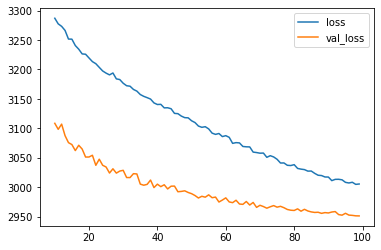

In [ ]:
# Plotting the DataFrame
history_df=pd.DataFrame(history.history)
history_df.loc[10:,['loss','val_loss']].plot()

# Trial model with reduced neural layers

In [ ]:
input_shape=[X_train.shape[1]]
no_target_columns = 1
model=keras.Sequential([
   layers.Dense(150,activation='relu',input_shape=input_shape,kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(150,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(150,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(50,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(50,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(36,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   layers.Dense(36,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   layers.Dropout(rate=0.2),
   #layers.Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   #layers.Dropout(rate=0.2),

   #layers.Dense(64,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   #layers.Dropout(rate=0.2),
   #layers.Dense(352,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   #layers.Dropout(rate=0.2),
   #layers.Dense(320,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   #layers.Dropout(rate=0.2),
   #layers.Dense(32,activation='relu',activity_regularizer=keras.regularizers.l2(1e-2)),
   #layers.Dropout(rate=0.3),
   #layers.Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(1)),
   #layers.Dropout(rate=0.2),

   layers.Dense(1,activation = 'linear')
])

In [ ]:
# Initializing the Optimizer values
optimizer=keras.optimizers.RMSprop(0.001)
metric1=keras.metrics.RootMeanSquaredError()
metric2=keras.metrics.MeanAbsoluteError()
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[metric1])



early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

history=model.fit(
    X_train,y_train,
    validation_split=0.7,
    epochs=100,
    batch_size=512,
    callbacks = [early_stopping],
    validation_data=(X_test,y_test)
)

Epoch 1/100
332/332 [==============================] - 8s 21ms/step - loss: 5960.0745 - root_mean_squared_error: 6957.9901 - val_loss: 1813.2609 - val_root_mean_squared_error: 2748.8926
Epoch 2/100
332/332 [==============================] - 7s 21ms/step - loss: 2103.1298 - root_mean_squared_error: 3065.3237 - val_loss: 1760.0270 - val_root_mean_squared_error: 2675.2551
Epoch 3/100
332/332 [==============================] - 7s 21ms/step - loss: 2032.8433 - root_mean_squared_error: 2991.6897 - val_loss: 1781.1411 - val_root_mean_squared_error: 2757.6946
Epoch 4/100
332/332 [==============================] - 7s 21ms/step - loss: 2013.9168 - root_mean_squared_error: 2967.0042 - val_loss: 1759.6604 - val_root_mean_squared_error: 2713.5273
Epoch 5/100
332/332 [==============================] - 7s 21ms/step - loss: 2009.5114 - root_mean_squared_error: 2967.9674 - val_loss: 1751.6786 - val_root_mean_squared_error: 2692.8496
Epoch 6/100
332/332 [==============================] - 7s 21ms/step - 

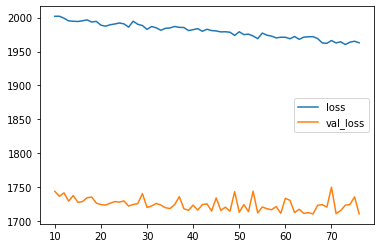

In [ ]:
# Plotting the DataFrame
history_df=pd.DataFrame(history.history)
history_df.loc[10:,['loss','val_loss']].plot()

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_predictions = pd.DataFrame({'Predicted Price': test_predictions,'Actual Price':y_test.values.flatten()})
test_predictions.head(10)

,Predicted Price,Actual Price
0,5510.186523,6023
1,5976.964844,2817
2,6833.708496,3069
3,5689.593750,9907
4,5218.590820,5885
5,7514.300293,7852
6,5199.985352,5906
7,5973.459473,7071
8,9133.610352,11793
9,7303.572266,6395


In [ ]:
prediction = model.predict(test)
prediction = pd.DataFrame(prediction,columns=["Sales"])
prediction.index.names=["Index"]
prediction.head()

,Sales
Index,
0,0.000021
1,5439.486816
2,7445.993164
3,5482.914062
4,5769.923340


In [ ]:
prediction.to_csv("pred_file.csv")